# Implementación de Algo SOM
### Desarrollado por :

Juan Camilo Cática

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [5]:
data = np.array([
    [1,1],
    [1.2,0.9],
    [1.1,1.1],
    [0.89,1.3],
    [4,4],
    [4.2,3.9],
    [4.1,4.1],
    [3.89,4.3],
    [1,4],
    [0.9,3.9],
    [1.1,4.1],
    [4,1],
    [3.9,0.9],
    [4.1,1.1],
])
data = MinMaxScaler(feature_range=(-1,1)).fit_transform(data,None)
y = [0,0,0,0,1,1,1,1,2,2,2,3,3,3]
data.shape

(14, 2)

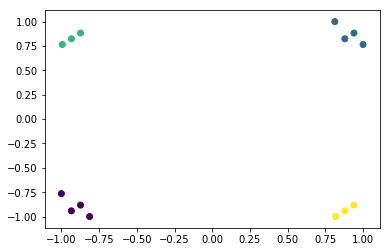

In [6]:
 plt.scatter(data[:,0],data[:,1],c=y);

In [7]:
data.shape

(14, 2)

### Finción de actualización de pesos del Algoritmo SOM

$ 𝒘_𝒋(𝑡 + 1) = 𝒘_𝒋(𝑡) + 𝛼 V(d(i,j),g)(𝒙_𝒊 − 𝒘_𝒋(𝑡)) $

## Clase SOM2D

In [25]:
import numpy as np
import pandas as pd
import math
from sklearn.base import BaseEstimator, TransformerMixin

class SOM2D(BaseEstimator, TransformerMixin):
    """
    Esta clase implementa un SOM (Self-Organizing Map) a partir de las dimensiones establecidas
    desde el método constructor.
    
    Desarrollado por:
        Juan Camilo Cática Buendía.
    """
    
    def __init__(self, hight, widht, alpha = 0.2, distance = 2, epochs = 100):
        """
        Método constructor de la clase SOM2D. 
        
        Este método inicializa algunos de los atributos implementados por el algoritmo a través de 
        los parametros de entrada. Sin embargo, algunos de estos son definidos tras el entrenamiento del 
        algotimo.
        
        La red neuronal o mapa que se genera con la implementación de esta clase es, en terminos estrictos,
        una matriz con número de filas igual a 'hight' y número de columans igual a 'widht'.
        
        Parametros:
        -----------
            hight: int.
                Establece la alturna en número de unidades de la red neuronal (SOM), es decir, el número
                de filas de la matriz que simula la red.
                
            widht: int.
                Establece la anchura en número de unidades de la red neuronal (SOM), es decir, el número
                de columnas de la matriz que simula la red.
                
            alpha: float, default 0.2.
                Se define como la taza de apendizaje y olvido del algotirmo SOM. 
                
            distance: float, default 2.
                Es la distancia maxima a la cual se desarrollará la propagación de actualización
                de los pesos de las neuronas vecinas. Es análogo a la técnica 'spreading activation'.
                
            epochs: int, default 100.
                Número de epocas definidas para desarrollar el entrenamiento de estimador.
                
        Atributos:
        ----------
            self.proximity_matrix:
                Este atributo es una matriz cuadrada con dimensiónes laterales iguales al número de neuronas
                o unidades 'self._units' definidas  por el producto entre los parametros hight y widht.
                
                Esta matriz contine las distancias en terminos de la composición del mapa entre cada una 
                de las neuronas que compone la red. 
                
                Este atributo se inicializa al momento de compilar la red, es decir, cuando se ejecuta
                el método 'self.compile()'.  
                
            self.decay_values:
                Este atributo es un diccionario que contiene el valor de decaimiento para cada neruona que 
                se encuentre en el rango de proximidad de cada una de las neuronas de la red que puedan
                llegar a ser la neurona ganadora en cada iteración.
                
                self.decay_values:{
                    neurona_ganadora0: [(neurona1, decay_val),(neurona2, decay_val),...,(neuronaN, decay_val)]
                    neurona_ganadora1: [(neurona0, decay_val),(neurona2, decay_val),...,(neuronaM, decay_val)]
                    ...
                }
                
                eje:
                    self.decay_values:{
                        0:[(1,0.98), (2,0.95), ... (n, ##)]
                        1:[(0,0.98), (2,0.91), ... (m, ##)]
                        ...
                        k:[(0,0.83), (1,0.95), ... (l, ##)]
                    }
                    donde: n, m, l son el maximo de neuronas que entran en el radio de cobertura definido
                    por 'distance' cuando la neurona ganadora en cada iteración reuslta ser 0, 1, ó k.
                    
            self.mean_distances:
                Este atributo es un vector que almacena la distncia media de cada neurona con respecto a las
                demás en termino de los vectores de pesos.
                
                Este atributo se emplea para generar la gráfica tipo panal de abeja por medio del método
                'self.plot()' cuando el valor del parametro 'som_map' de dicho método es igual a "distance".
            
            self.label_matrix:
                Esta matriz se inicializa cuando se ha entrenado el estimador con etiqeutas de clase. Donde
                el número de filas representa el numero de neuronas y el número de coumnas las etiquetas de
                clase.
                    
                Los valores contenidos en esta matriz son basicamente el número de registros que han sido 
                asociado a cada neurona. Estos valores pueden estar modificados en por efectos de la función
                de decaimiento.
            
            self.labels:
                Este atributo es una vector de etiquetas, el cual se obtiene a partir de la matriz 
                'self.label_matrix', Sabiendo que cada fila de la matriz 'self.label_matrix' representa una
                neurona, y los valores de las columnas representan las etiquetas, el valor de 'self.labels'
                se optiene a partir del valor maximo de cada columna para cada una de las filas (neuronas).
                
            self.W
                Este atributo es una matriz que representa los vectores de pesos de cada una de las
                neuronas de la red neuronal del  algorimo SOM. Esta matriz se inicializa al momento de 
                entrenar el modelo, es decir al momento de invocar el metodo 'self.fit()'.
                
            self.quantization_error: float
                Error de cuantificación sobre el conjunto de datos de entrenamiento.
                
            IMPORTANTE:    
                Ejemplo de la Matriz de neuronas del Algoritmo SOM (Representación Matricial):
                        j
                      0,1,2
                    i 3,4,5
                      6,7,8

                La matriz anterior es una representación reordenada t reformateada del vector de neuronas.
                La siguiente matriz es la matriz de priximidad (self.proximity_matrix) la cual contiene las 
                distancias en terminos del arreglo de la matriz de cada una de las neuronas en la representación
                matricial.
                           k1
                       0 1 2 3 4 5 
                       -----------
                    0| 0 1 2 1 . . 
                    1| 1 0 1 . 1 . 
                k2  2| 2 1 0 
                    3| 1 .   0
                    4| . 1     0
                    5| . .       0
        """
        # -------------------------------------------------
        # ATRIBUTOS DEFINIDOS POR LOS PARÁMETROS DE ENTRADA
        #
        self._widht = widht
        self._hight = hight
        self._alpha = alpha
        self._distance = distance
        self._epochs = epochs
        self._units = hight*widht
        
        # ---------------------------------------------------
        # ATRIBUTOS DE CONTROL DE ENTRENAMIENTO Y COMPILACIÓN
        #
        self._compiled = False
        self._trained = False
        self._labeled = False
        
        # ---------------------------------------------------------------
        # ATRIBUTOS QUE SE DEFINEN DURANTE LA COMPILACIÓN Y ENTRENAMIENTO
        #
        self.proximity_matrix = None
        self.decay_values = dict()
        self.mean_distances = []
        self.label_matrix = []
        self.labels = []
        self.W = None
        self.quantization_error = -1
    
    def fit(self, X, y = None):
        """
        Método de entrenamiento.
        
        Este método se ejecuta en cuatro etapas, las cuales son:
            1.  ETAPA DE ACTUALIZACIÓN DE LOS PESOS DE LAS NEURONAS. 
                Esto se desarrolla bajo el algoritmo SOM.
                $ 𝒘_𝒋(𝑡 + 1) = 𝒘_𝒋(𝑡) + 𝛼 V(d(i,j),g)(𝒙_𝒊 − 𝒘_𝒋(𝑡)) $
                
            2.  GENERACIÓN DE DISTANCIAS MEDIAS ENTRE NEURONAS.
            
            
            3.  ETIQUETAS DE LAS NEURONAS.
            
            
            4.  CÁLCULO DEL ERROR DE CUANTIFICACION (QE: QUANTIFICATION ERROR).
            
        
        ADVERTENCIA: 
            Los datos de entrada por el vector 'y' deben estar codificados de 0 a n.
            Donde el valor de 'n' es el númeor de clases posibles.
            
        IMPORTANTE:
            Este método no se encuentra optimizado en términos de reutilización de código.
            En cada etapa se implementa código similar. (REVISAR POSIBILIDADES).
                   
        Parametro:
        ----------
        
            X: numpy.array
                Conjunto de datos sin etiquetas de clase.
            
            y: list or numpy.array, default None.
                Etiquetas de classe para cada uno de los registros de 'X'.
            
        """
        assert self._compiled, "No se ha compilado la red neuronal (SOM)."
        assert not self._trained, "La red ya fue entrenada"
        _, n_variables = X.shape
        self.W = np.random.randn(self._units, n_variables)
        self.W_old = self.W.copy()
        serie_i = pd.Series(range(len(X)))
        
        # ---------------------------------------------------
        # ETAPA DE ACTUALIZACIÓN DE LOS PESOS DE LAS NEURONAS
        #
        for epoch in range(self._epochs):
            for i in serie_i.sample(frac=1):
                nomrs = []
                for W_j in self.W:
                    nomrs.append(np.linalg.norm(X[i] - W_j))
                wn = np.argmin(nomrs)
                 
                for j, decay_val in self.decay_values[wn]:
                    self.W[j] = self._update(self.W[j], X[i], decay_val)
        
        # ----------------------------------------------
        # GENERACIÓN DE DISTANCIAS MEDIAS ENTRE NEURONAS
        #
        for i in range(len(self.W)):
            distances = []
            for j in range(len(self.W)):
                distances.append(np.linalg.norm(self.W[i] - self.W[j]))
            self.mean_distances.append(np.mean(distances))
        
        # -------------------------
        # ETIQUETAS DE LAS NEURONAS
        #
        if y:
            self.labels = pd.Series(y).unique()
            self.label_matrix = np.zeros((self._units, len(self.labels)))
            
            for xi, yi in zip(X,y):
                nomrs = []
                for W_j in self.W:
                    nomrs.append(np.linalg.norm(xi - W_j))
                wn = np.argmin(nomrs)

                for j, decay_val in self.decay_values[wn]:
                    self.label_matrix[j, yi] += decay_val 
            self._labeled = True
            
        # ------------------------------------------------------------
        # CÁLCULO DEL ERROR DE CUANTIFICACION (QE: QUANTIZATION ERROR)
        #
        q_error = 0
        for xi in X:
            nomrs = []
            for Wj in self.W:
                nomrs.append(np.linalg.norm(xi - Wj))
            wn = np.argmin(nomrs)
            q_error += nomrs[wn]
        self.quantization_error = q_error / len(X)
        self._trained = True
    
    def compile(self):
        """
        Este métod debe ser ejecutado antes de ejecutar el método 'self.fit()'.
        
        Este metodo inicializa la matriz de proximidad (self.proximity_matrix) se inicializa con valores de cero.
        Posteriormente calcula todos los valores de proximidad de entre las neuronas en terminos del arreglo 
        matricial.
        
        Finalmente, se asignan los valors de decamiento para cada una de las combinaciones de neuronas 
        (neurona genadora y neurona proxima), donde las neuronas proximas son seleccinadas a partir del rango
        definido por el parametro 'distance' del método constructor de cada una de las neuronas existentes.
        
        Los valores de decaimiento son almacenados por un diccionario. Para entender el formato del diccionario
        ver self.decay_values en el docstring del metodo constructor en la sección de atributos.
        
        IMPORTANTE: 
            Este metodo puede tardar de manera considerable en función de las neuronas que componen la red SOM.
        """
        self.proximity_matrix = np.zeros((self._units,self._units))
        for k1 in range(self._units):
            for k2 in range(k1):
                vect_k1 = self._coordinates_ij(k1)
                vect_k2 = self._coordinates_ij(k2)
                distance = np.linalg.norm(vect_k1 - vect_k2)
                self.proximity_matrix[k1,k2] = self.proximity_matrix[k2,k1] = distance
                
        for k1 in range(self._units):
            neurons_decays = []
            for k2 in range(self._units):
                proximity = self.proximity_matrix[k1,k2]
                if self._distance >= proximity:
                    neurons_decays.append((k2,self._decay_function(proximity))) 
            self.decay_values[k1] = neurons_decays
        self._compiled = True    
    
    
    def _coordinates_ij(self, k):
        """
        Este método permite obtener la cardinalidad de cada neurona bajo una representación matricial.
        Ya que esta clase implementa el conjunto de neuronas como un vector.
        
        Parametros:
        -----------
        
            k: int
                Posición de la neurona en el vector 'self.W'
            
        """
        i = k // self._widht
        j = k % self._widht
        return np.array([i,j])
    
    def _decay_function(self, dist):
        """
        La función de decaimiento.
        
        Parametro:
        ----------
        
            dist: float
                Distancia con la cual obtiene el valor de decaimiento.
        """
        return math.e**(-dist)
    
    def _update(self, W_j, x_i, decay_val):
        """
        Función para la actualización del peso de las neuronas, en esta se contempla el valor de decaimiento
        en el proceso de actualización.
        """
        return W_j + self._alpha * (decay_val * (x_i - W_j))
    
    def plot(self, name = "", som_map = "distance", ticklabels = None, figsize=(7, 4), 
             distance_cmap = 'gray_r', labeled_cmap = None):
        """
        Metodo para plotear la gráfica de panal de abeja.
        
        Esta gráfica puede esta basada en un vector de distancias o en un vector de etiquetas de clase
        según el entrenamiento del estimador.
        
        parametros:
        -----------
        
            name: str
                Nombre de la gráfica.
                
            som_map: str
                Tipo de mapa a proyectar. 
                'distance': Mapa de distancias entre las neuronas
                'labeled' : MApa de coloración. Solo funcióna cuando se ha entrenado con etiquetas de clase.
            
            ticklabels: list, default None.
                Nombre de las etiquetas de clase
            
            figsize: tuple
                Tamaño de la figura.
            
            distance_cmap:
                cmap para la coloración del mapa cuando el valor de 'som_map' es igual a 'distance'.
            
            labeled_cmap:
                cmap para la coloración del mapa cuando el valor de 'som_map' es igual a 'labeled'.
        """
        assert self._compiled, "No se ha compilado la red neuronal (SOM) :("
        assert self._trained, "No se ha entrenado la red :("
        if ticklabels:
            assert len(self.labels)==len(ticklabels), "'ticklabels' no es de igual longitud que 'self.labels'"
            
        gridsize = max(self._widht,self._hight)
        x = []
        y = []
        if som_map == "distance":
            fig = plt.figure(figsize=figsize)
            for k_neuron in range(self._units):
                i,j = self._coordinates_ij(k_neuron)
                x.append(j)
                y.append(i)

            hb = plt.hexbin(x, y, C = self.mean_distances, gridsize = gridsize, cmap = distance_cmap)
            plt.title("Mean Distance")
            cb = fig.colorbar(hb)
            cb.set_label('Distance')

        elif som_map == "labeled":
            assert self._labeled, "No se especificaron etiquetas durante el entrenamiento"
            fig = plt.figure(figsize=figsize)
            label_neurons = []
            for k_neuron in range(self._units):
                i,j = self._coordinates_ij(k_neuron)
                W_k = self.label_matrix[k_neuron]
                if W_k.sum():
                    x.append(j)
                    y.append(i)
                    label_neurons.append(np.argmax(W_k))

            hb = plt.hexbin(x, y, C=label_neurons, gridsize = gridsize, cmap = labeled_cmap)
            plt.title(f"{name} SOM")
            cb = fig.colorbar(hb)
            cb.set_label('label')
            cb.set_ticks(ticks=self.labels)
            if ticklabels:
                cb.set_ticklabels(ticklabels=ticklabels)
        else:
            raise ValueError("El valor del parámetro 'som_map' no es correcto :(")
        plt.show()

## Quick Test

In [41]:
som = SOM2D(5,5, alpha = 0.01, distance = 1 , epochs= 100)
som.compile()
som.fit(data,y)

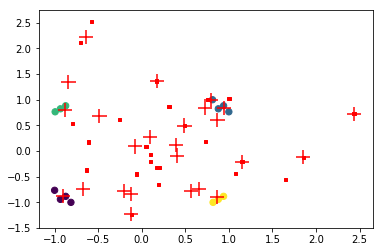

In [42]:
plt.scatter(data[:,0],data[:,1],c=y,s=40);
plt.scatter(som.W[:,0],som.W[:,1],s=200, marker = "+",c=[(1,0,0)]*len(som.W));
plt.scatter(som.W_old[:,0],som.W_old[:,1],s=10, marker = "s",c=["r"]*len(som.W));

## Mapas

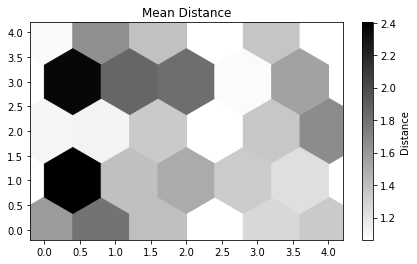

In [43]:
som.plot()

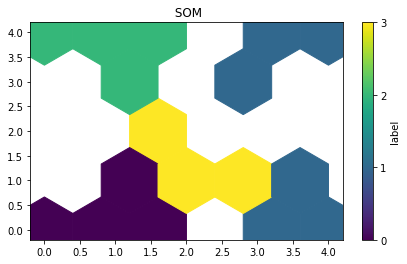

In [44]:
som.plot(som_map="labeled")

## Quantization Error

In [46]:
som.quantization_error

0.07856338704247315

In [47]:
math.e

2.718281828459045